# Text Classification - BBC News Data

## Overview

The following notebook is created out of inspiration from the source [here](https://colab.research.google.com/github/srushtidhope/bbc-text-classification/blob/master/bbc_text_classification.ipynb#scrollTo=22L7TrqYtFiz) 


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


# NLTK modules
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import re

from gensim.models import Word2Vec # Word2Vec module

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/kaggle/input/bbc-fulltext-and-category/bbc-text.csv


## Loading Dataset

In [2]:
news_data = pd.read_csv('/kaggle/input/bbc-fulltext-and-category/bbc-text.csv')

In [3]:
print(f"Shape : {news_data.shape}, \n\nColumns: {news_data.columns}, \n\nCategories: {news_data.category.unique()}")

# print sample data
news_data.head().append(news_data.tail())

Shape : (2225, 2), 

Columns: Index(['category', 'text'], dtype='object'), 

Categories: ['tech' 'business' 'sport' 'entertainment' 'politics']


,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
2220,business,cars pull down us retail figures us retail sal...
2221,politics,kilroy unveils immigration policy ex-chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...
2223,politics,how political squabbles snowball it s become c...
2224,sport,souness delight at euro progress boss graeme s...


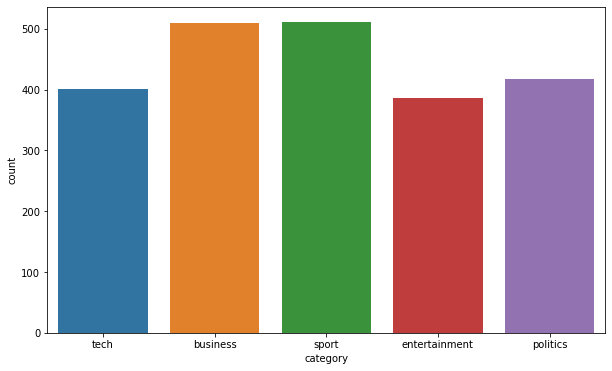

In [4]:
# Plot category data
plt.figure(figsize=(10,6))
sns.countplot(news_data.category)
plt.show()

## Data Preparation

In [5]:
class DataPreparation:
    def __init__(self, data, column='text'):
        self.df = data
        self.column = column
    
    def preprocess(self):
        self.tokenize()
        self.remove_stopwords()
        self.remove_non_words()
        self.lemmatize_words()
        
        return self.df
    
    def tokenize(self):
        self.df['clean_text'] = self.df[self.column].apply(nltk.word_tokenize)
        print("Tokenization is done.")
    
    def remove_stopwords(self):
        stopword_set = set(nltk.corpus.stopwords.words('english'))
        
        rem_stopword = lambda words: [item for item in words if item not in stopword_set]
        
        self.df['clean_text'] = self.df['clean_text'].apply(rem_stopword)
        print("Remove stopwords done.")
    
    def remove_non_words(self):
        """
            Remove all non alpha characters from the text data
            :numbers: 0-9
            :punctuation: All english punctuations
            :special characters: All english special characters
        """
        regpatrn = '[a-z]+'
        rem_special_chars = lambda x: [item for item in x if re.match(regpatrn, item)]
        self.df['clean_text'] = self.df['clean_text'].apply(rem_special_chars)
        print("Removed non english characters is done.")
        
    def lemmatize_words(self):
        lemma = nltk.stem.wordnet.WordNetLemmatizer()
        
        on_word_lemma = lambda x: [lemma.lemmatize(w, pos='v') for w in x]
        
        self.df['clean_text'] = self.df['clean_text'].apply(on_word_lemma)
        print("Lemmatization on the words.")

In [6]:
data_prep = DataPreparation(news_data)

cleanse_df = data_prep.preprocess()

Tokenization is done.
Remove stopwords done.
Removed non english characters is done.
Lemmatization on the words.


In [7]:
cleanse_df['clean_text']

0       [tv, future, hand, viewers, home, theatre, sys...
1       [worldcom, boss, leave, book, alone, former, w...
2       [tigers, wary, farrell, gamble, leicester, say...
3       [yeading, face, newcastle, fa, cup, premiershi...
4       [ocean, twelve, raid, box, office, ocean, twel...
                              ...                        
2220    [cars, pull, us, retail, figure, us, retail, s...
2221    [kilroy, unveil, immigration, policy, ex-chats...
2222    [rem, announce, new, glasgow, concert, us, ban...
2223    [political, squabble, snowball, become, common...
2224    [souness, delight, euro, progress, boss, graem...
Name: clean_text, Length: 2225, dtype: object

## Feature Engineering

In [8]:
vec_model = Word2Vec(cleanse_df['clean_text'])

w2v = dict(zip(vec_model.wv.index2word, vec_model.wv.syn0))

## Classification with Custom Vectorizer

In [9]:
class Vectorizer(object):
    def __init__(self, vec):
        self.vec = vec
        self.dim = len(vec.values())
        
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        return np.array([np.mean([self.vec[w] for w in words if w in self.vec] or [np.zeros(self.dim)], axis=0) for words in X])
    

    

# Classifier class
class Classifier(object):
    def __init__(self, model, param):
        self.model = model
        self.param = param
        self.gsearch = GridSearchCV(self.model, self.param, cv=5, error_score=0, refit=True)
        
    def fit(self, X, y):
        return self.gsearch.fit(X, y)
    
    def predict(self, X):
        return self.gsearch.predict(X)

clf_models = {
    'Naive Bayes': GaussianNB(),
    'SVC': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'SGD Classifier': SGDClassifier(),
    'Perceptron': MLPClassifier()
}

clf_params = {
    'Naive Bayes': {},
    'SVC' : {'kernel': ['linear', 'rbf']},
    'Decision Tree': {'min_samples_split': [2, 5]},
    'SGD Classifier': { 'penalty': ['l2', 'l1', 'elasticnet'] },
    'Perceptron': {'activation': ['tanh', 'relu']}
}

## Split the dataset

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(cleanse_df['clean_text'], cleanse_df['category'], test_size=0.2, shuffle=True)

In [11]:
# Iterate through the model names
for key in clf_models.keys():
    
    clf = Pipeline([('Word2Vec', Vectorizer(w2v)), ('Classifier', Classifier(clf_models[key], clf_params[key]))])
    
    # Fitting the data
    clf.fit(X_train, y_train)
    
    y_preds = clf.predict(X_valid)
    
    
    print(key, ":")
    print("Accuracy: %1.3f \tPrecision: %1.3f \tRecall: %1.3f \tF1-Score: %1.3f\n" % (accuracy_score(y_valid, y_preds),
                                                                                     precision_score(y_valid, y_preds, average='macro'),
                                                                                     recall_score(y_valid, y_preds, average='macro'),
                                                                                     f1_score(y_valid, y_preds, average='macro')))

Naive Bayes :
Accuracy: 0.919 	Precision: 0.920 	Recall: 0.921 	F1-Score: 0.920

SVC :
Accuracy: 0.915 	Precision: 0.914 	Recall: 0.913 	F1-Score: 0.912

Decision Tree :
Accuracy: 0.906 	Precision: 0.905 	Recall: 0.906 	F1-Score: 0.905

SGD Classifier :
Accuracy: 0.915 	Precision: 0.922 	Recall: 0.910 	F1-Score: 0.912

Perceptron :
Accuracy: 0.937 	Precision: 0.937 	Recall: 0.937 	F1-Score: 0.936



## Vectorization using TFIDF

In [17]:
def vectorize(vector, X_train, X_test):
    vector_fit = vector.fit(X_train)
    
    X_train_vec = vector_fit.transform(X_train)
    X_test_vec = vector_fit.transform(X_test)
    
    print("Vectorization is completed.")
    return X_train_vec, X_test_vec

def label_encoding(y_train):
    """
        Encode the given list of class labels
        :y_train_enc: returns list of encoded classes
        :labels: actual class labels
    """
    lbl_enc = LabelEncoder()
    
    y_train_enc = lbl_enc.fit_transform(y_train)
    labels = lbl_enc.classes_
    
    return y_train_enc, labels

def algorithm_stack(models, params, X_train, X_test, y_train, y_test):
    
    if not set(models.keys()).issubset(set(params.keys())):
        raise ValueError('Keys do not match')
        
    for key in models.keys():
        model = models[key]
        param = params[key]
        
        gs = GridSearchCV(model, param, cv=5, error_score=0, refit=True)
        gs.fit(X_train, y_train)
        
        y_pred = gs.predict(X_test)
        
        print(key, ":")
        print("Accuracy: %1.3f \tPrecision: %1.3f \tRecall: %1.3f \tF1-Score: %1.3f\n" % (accuracy_score(y_test, y_pred),
                                                                                     precision_score(y_test, y_pred, average='macro'),
                                                                                     recall_score(y_test, y_pred, average='macro'),
                                                                                     f1_score(y_test, y_pred, average='macro')))
    return


In [13]:
# Encode the class labels
y_enc_train, labels = label_encoding(news_data['category'])

# Split from the loaded dataset
X_train, X_valid, y_train, y_test = train_test_split(news_data['text'], y_enc_train, test_size=0.2, shuffle=True)

# TFIDFVectorizer 
X_train_vec, X_valid_vec = vectorize(TfidfVectorizer(), X_train, X_valid)

print(X_train_vec.shape, X_valid_vec.shape)

clf_models = {
    'Naive Bayes': MultinomialNB(),
    'SVC': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'SGD Classifier': SGDClassifier(),
    'Perceptron': MLPClassifier()
}


# Modified parameters
clf_params = {
    'Naive Bayes': {'alpha': [0.5, 1], 'fit_prior': [True, False] },
    'SVC' : {'kernel': ['linear', 'rbf']},
    'Decision Tree': {'min_samples_split': [1, 2, 5]},
    'SGD Classifier': { 'penalty': ['l2', 'l1', 'elasticnet'] },
    'Perceptron': {'alpha': [0.0001, 0.001], 'activation': ['tanh', 'relu']}
}

Vectorization is completed.
(1780, 26955) (445, 26955)


In [15]:
y_train

array([2, 2, 0, ..., 4, 3, 3])

In [ ]:
algorithm_stack(clf_models, clf_params, X_train_vec, X_valid_vec, y_train, y_test)

Naive Bayes :
Accuracy: 0.973 	Precision: 0.974 	Recall: 0.970 	F1-Score: 0.971

SVC :
Accuracy: 0.989 	Precision: 0.989 	Recall: 0.988 	F1-Score: 0.988

Decision Tree :
Accuracy: 0.834 	Precision: 0.833 	Recall: 0.828 	F1-Score: 0.830

SGD Classifier :
Accuracy: 0.984 	Precision: 0.984 	Recall: 0.983 	F1-Score: 0.984

